### Imports

In [40]:
import os
import re
import pdfplumber 
import pandas as pd
import numpy as np
import spacy
import PyPDF2  # or pdfplumber for better text extraction

### Function to extract text from PDFs 

In [4]:
# Define a function to extract information from a PDF
def extract_information(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        resume_text = ""
        for page in pdf.pages:
            resume_text = " ".join([resume_text, page.extract_text()])
    resume_text = resume_text.strip()
    return resume_text

### Defining Regex to extract Skills & Education from extracted resume text

In [5]:
# Define a function to extract Skills, and Education
def extract_details(resume_text):
    # Define regular expressions to extract Skills & Education
    skills_pattern = r'Skills\n([\s\S]*?)(?=\n[A-Z]|$)' 
    education_pattern = r'Education\n([\s\S]*?)(?=\n[A-Z][a-z]*\n|$)'
    
    # Get Skills & Education
    skills_match = re.findall(skills_pattern, resume_text, re.DOTALL)
    education_match = re.findall(education_pattern, resume_text, re.DOTALL)
    
    # Skills & Education
    if len(skills_match)!=0:
        skills = skills_match[0]
    else:
        skills_pattern = r'skills\n((?:.*)*)' 
        skills_match = re.findall(skills_pattern, resume_text, re.DOTALL)
        if len(skills_match)!=0:
            skills = skills_match[0]
        else:
            skills = None
            
    if len(education_match)!=0:
        education = education_match[0]
    else:
        education = None
    
    return {
        'Skills': skills,
        'Education': education
    }

### Extracting CVs

In [46]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def extract_text_from_pdf(pdf_path):
    #Extracts text from a PDF file.
    with open(pdf_path, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        text = " ".join([page.extract_text() for page in reader.pages if page.extract_text()])
    return text

def extract_details(text):
    #Extracts skills and education details from resume text using spaCy.
    doc = nlp(text)
    skills = []
    education = []

    for ent in doc.ents:
        if ent.label_ in ["ORG", "EDUCATION"]:  # Adjust based on spaCy entity types
            education.append(ent.text)
        elif ent.label_ in ["SKILL", "WORK_OF_ART", "PRODUCT"]:  # Skill-related entities
            skills.append(ent.text)

    return {
        "skills": ", ".join(set(skills)),
        "education": ", ".join(set(education))
    }

# Define folder path
data_folder = r'C:\Users\prach\Downloads\Resume-to-Job Matcher\data'
resume_data = []

# Iterate through sub-folders and extract data from PDFs
for category_folder in os.listdir(data_folder):
    category_path = os.path.join(data_folder, category_folder)
    if os.path.isdir(category_path):
        for pdf_file in os.listdir(category_path):
            if pdf_file.endswith('.pdf'):
                pdf_path = os.path.join(category_path, pdf_file)
                
                text = extract_text_from_pdf(pdf_path)
                details = extract_details(text)
                
                # Adding Category & ID
                details['ID'] = pdf_file.replace('.pdf', '')
                details['Category'] = category_folder
                
                resume_data.append(details)

print('PDF Extraction Done!')

# Convert to DataFrame and save
resume_df = pd.DataFrame(resume_data)
resume_df.to_csv('./skills_education.csv', index=False)
print('Data saved to skills_education.csv')


PDF Extraction Done!
Data saved to skills_education.csv


### Analyzing Null Values

In [47]:
# Null values
resume_df.isna().sum()

skills       0
education    0
ID           0
Category     0
dtype: int64

In [53]:
print(resume_df[(resume_df.skills.isna() & resume_df.education.isna())])

Empty DataFrame
Columns: [skills, education, ID, Category]
Index: []


In [55]:
# We are left with 1009 resumes after removing those 6 resumes with null data in both of them
cv_df = resume_df.copy()
cv_df.head()

,skills,education,ID,Category
0,"Cold, Excel","WFX, State\n \nManage, Staffing Coordinator\n ...",10228751,BUSINESS-DEVELOPMENT
1,Associate of Arts\n \n: \nGolf Management\n \n...,"LLC, Professional Golf Management\n \nCity\n \...",10235211,BUSINESS-DEVELOPMENT
2,"The Over Achiever of the Year, Fortune 500, Ou...","State\n \nFinancial Operations\nExecutive, Sal...",10289113,BUSINESS-DEVELOPMENT
3,Ph.D.,"Birst, Business Management or Sales, Mailchimp...",10501991,BUSINESS-DEVELOPMENT
4,"Fortune 500, Excel","Human Resources, Darton State College, Communi...",10541358,BUSINESS-DEVELOPMENT


In [56]:
# New number of null values in Skills & Education Section
cv_df.isna().sum()

skills       0
education    0
ID           0
Category     0
dtype: int64

In [58]:
# Null values in Skills Section
cv_df[cv_df.skills.isna()]

,skills,education,ID,Category


In [59]:
# Null values in Education Section
cv_df[cv_df.education.isna()]

,skills,education,ID,Category


### Distribution of Different Resumes

In [60]:
cv_df.Category.value_counts()

Category
BUSINESS-DEVELOPMENT      120
INFORMATION-TECHNOLOGY    120
ENGINEERING               118
FINANCE                   118
CONSULTANT                115
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
DIGITAL-MEDIA              96
Name: count, dtype: int64

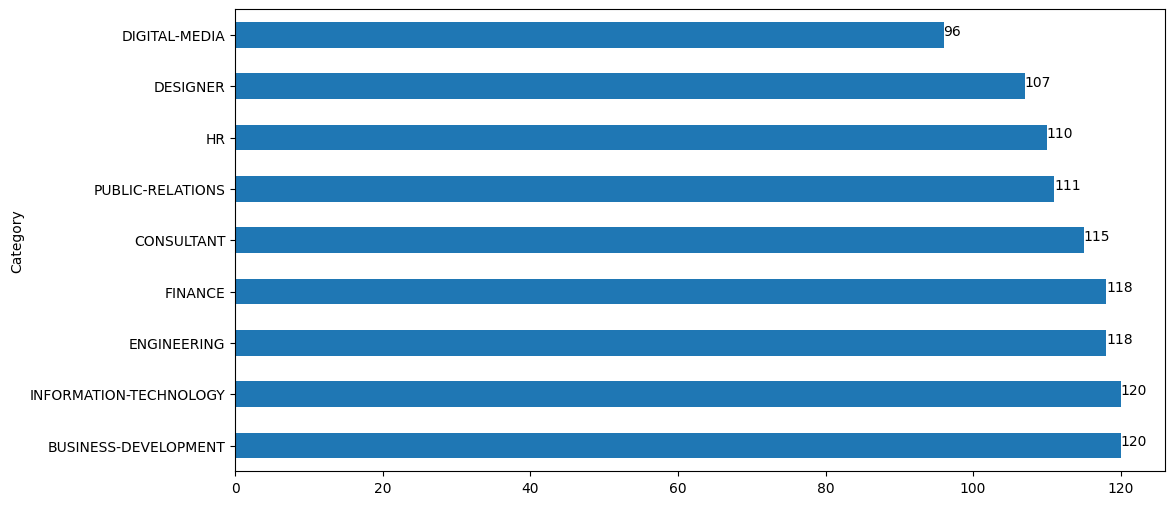

In [61]:
# We can see here the distribution of different CV categories

plt.figure(figsize=(12,6))
cv_df.Category.value_counts().plot(kind='barh')
for index, value in enumerate(cv_df.Category.value_counts().values):
    plt.text(value, index, str(value))
plt.show();